In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

In [11]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)
    
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    plt.show()

In [22]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf_i = clf.fit(X_train, Y_train, sample_weight=np.array(w))
        pred_train_i = clf_i.predict(X_train)
        pred_test_i = clf_i.predict(X_test)
        
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 1./2. * np.log((1 - err_m)/err_m)
        # New weights
        w = w * np.exp(-alpha_m * Y_train * pred_train_i)
        w = w / np.sum(w)
        #print(M, w)
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)



In [4]:
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

In [5]:
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.ix[:,:-1], train.ix[:,-1]
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]

In [6]:
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)

In [23]:
%%time
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

CPU times: user 7min 6s, sys: 1.53 s, total: 7min 7s
Wall time: 7min 8s


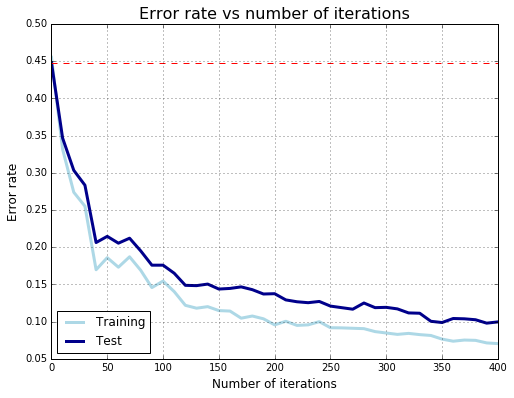

In [24]:
%matplotlib inline
plot_error_rate(er_train, er_test)